In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import torch
import torch.utils.data as data 

from omegaconf import OmegaConf
from torchvision import transforms
from torch.nn.parallel import DistributedDataParallel as DDP
# 
from contrastive_learning.tests.test_model import load_lin_model, predict_traj_actions
from contrastive_learning.tests.animate_markers import AnimateMarkers
from contrastive_learning.datasets.dataloaders import get_dataloaders

from contrastive_learning.models.custom_models import LinearInverse

### Model Loading
Create the distributed group
Load the linear inverse model from the saved path

In [2]:
# Start the multiprocessing to load the saved models properly
os.environ["MASTER_ADDR"] = "localhost"
os.environ["MASTER_PORT"] = "29504"

torch.distributed.init_process_group(backend='gloo', rank=0, world_size=1)
torch.cuda.set_device(0)

In [3]:
# Set the device and out_dir
device = torch.device('cuda:0')
out_dir = '/home/irmak/Workspace/DAWGE/contrastive_learning/out/2022.07.15/19-57_pli'
cfg = OmegaConf.load(os.path.join(out_dir, '.hydra/config.yaml'))
model_path = os.path.join(out_dir, 'models/lin_model.pt')

# Load the encoder
lin_model = load_lin_model(cfg, device, model_path)

In [4]:
print(lin_model)

DistributedDataParallel(
  (module): LinearInverse(
    (model): Sequential(
      (0): Linear(in_features=32, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=16, bias=True)
      (3): ReLU()
      (4): Linear(in_features=16, out_features=2, bias=True)
    )
  )
)


### Action Animation
1. Dump every predicted action for given data directory
2. Save the predicted and current action in a video

In [5]:
demo_name = 'box_marker_7'
exp_name = '2022.07.15-19-57_pli'
data_dir = '/home/irmak/Workspace/DAWGE/src/dawge_planner/data/{}'.format(demo_name)
dump_dir = '/home/irmak/Workspace/DAWGE/contrastive_learning/tests/animations'
dump_file = '{}_{}.mp4'.format(demo_name, exp_name)

fps = 15

In [6]:
predict_traj_actions(data_dir, lin_model, device, cfg) # Dumps the predicted actions for that data directory

FileNotFoundError: [Errno 2] No such file or directory: '/home/irmak/Workspace/DAWGE/src/dawge_planner/data/pos_corners.pickle'

predicted_actions.shape: (96, 2), len(pos_corners): 96
Animation saved to: /home/irmak/Workspace/DAWGE/contrastive_learning/tests/animations/box_marker_7_action_test.mp4


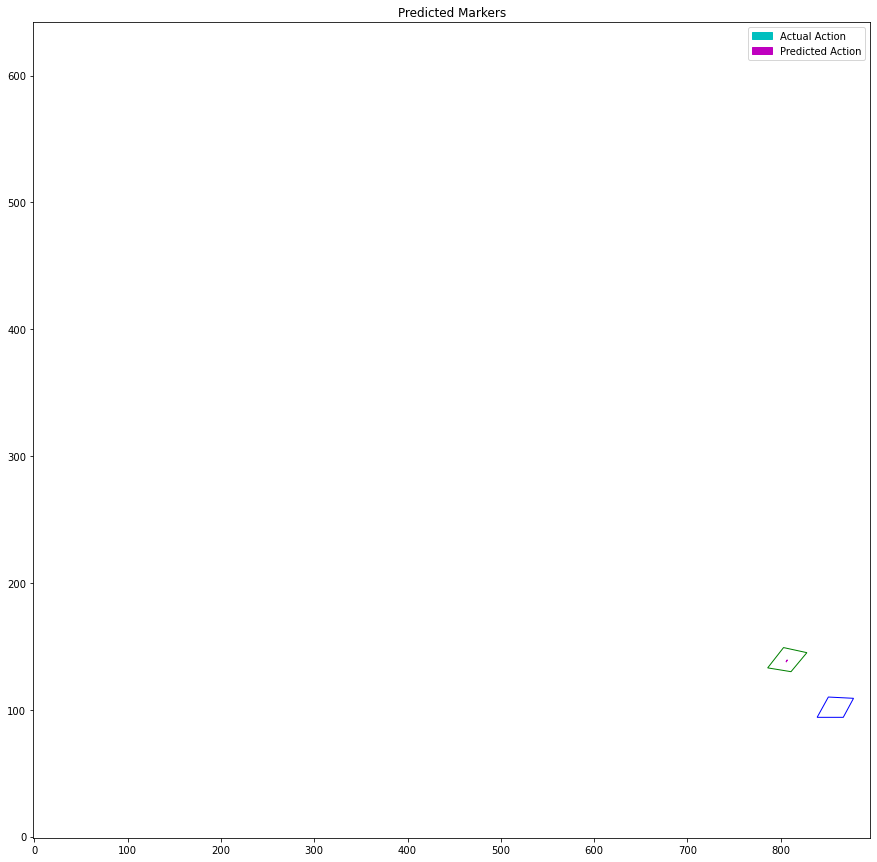

In [7]:
AnimateMarkers(
    data_dir = data_dir, 
    dump_dir = dump_dir, 
    dump_file = dump_file, 
    fps = fps,
    mult_traj = False,
    show_predicted_action = True 
) # Saves them in the given dump_file

### Action Prediction Image
Predict the action for each frame in the test dataset and dump them in a grid image

In [8]:
cfg.batch_size = 32
train_loader, test_loader, dataset = get_dataloaders(cfg)

In [9]:
len(test_loader.dataset)
batch = next(iter(test_loader))
curr_pos, next_pos, action = [b.to(device) for b in batch]
pred_action = lin_model(curr_pos, next_pos)

curr_pos.shape

torch.Size([32, 16])

In [10]:
print(curr_pos[0])

tensor([-0.5692, -0.0498, -0.4707, -0.1806, -0.3293, -0.1079, -0.4279,  0.0229,
        -0.7834,  0.1464, -0.6463,  0.2336, -0.7620,  0.3717, -0.9033,  0.2700],
       device='cuda:0')


In [11]:
dataset.denormalize_corner(curr_pos[0].cpu().detach().numpy())

array([[335.99999339, 214.00000002],
       [358.99999757, 195.99999902],
       [392.00000024, 206.00000037],
       [369.00000302, 224.00000009],
       [285.99999398, 240.99999999],
       [318.00000585, 252.99999997],
       [291.00000366, 272.00000029],
       [258.00000099, 257.99999963]])

(4, 8)


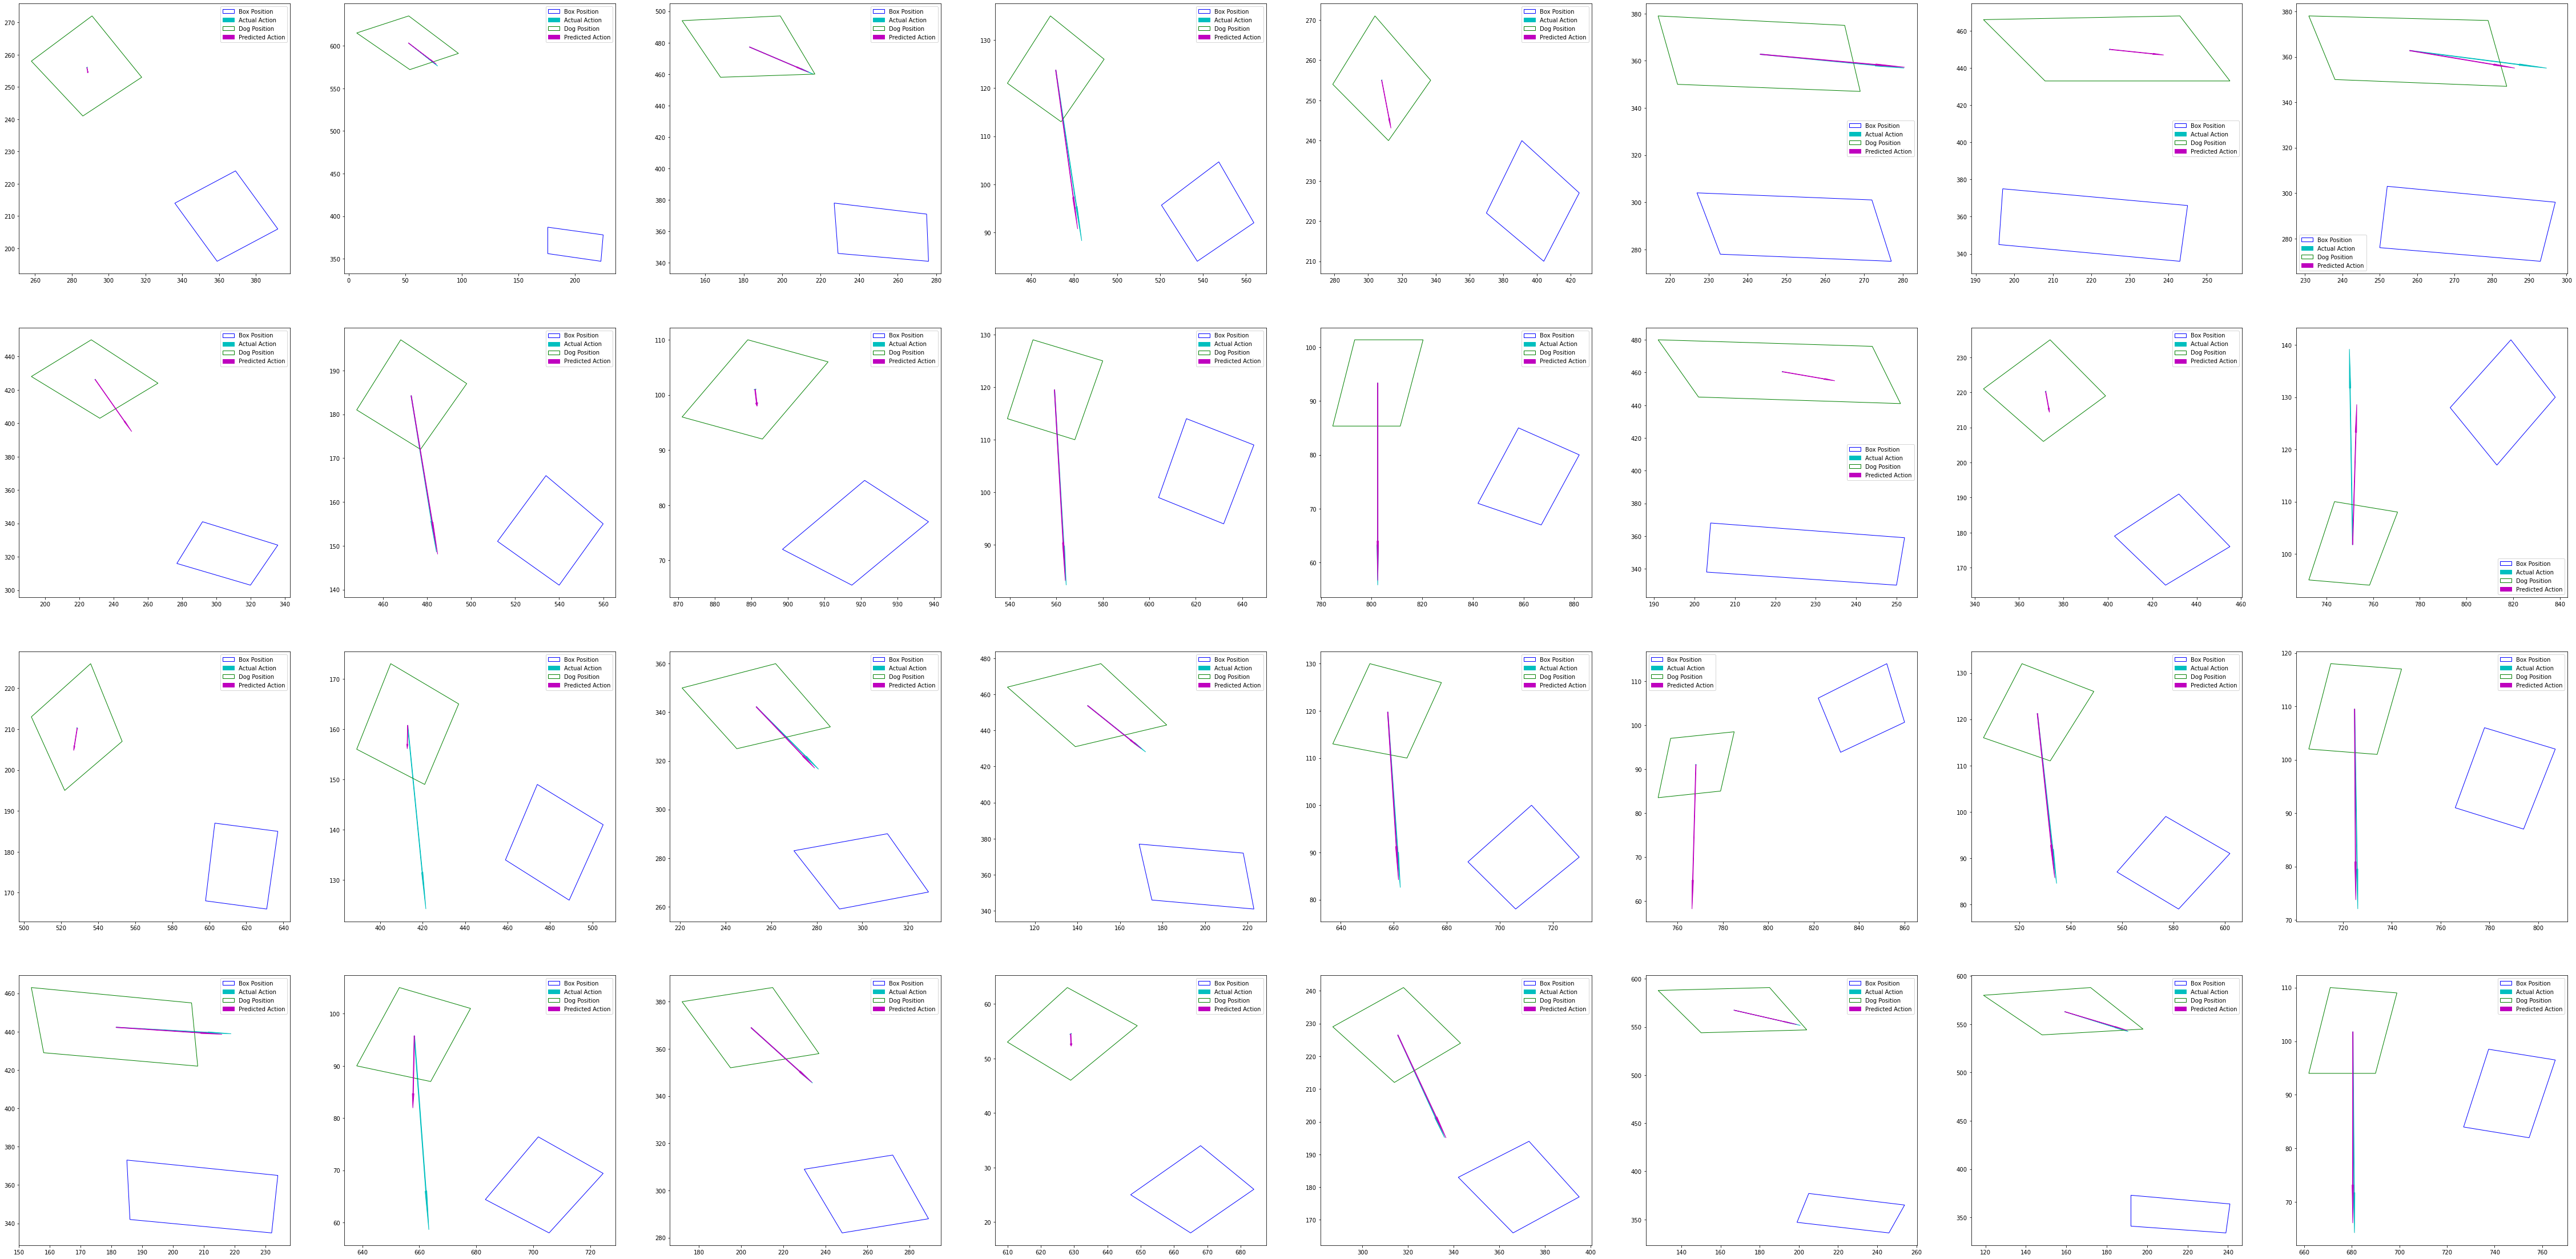

In [19]:
nrows = 4
ncols = int(cfg.batch_size / nrows)
fig, axs = plt.subplots(figsize=(ncols*10,nrows*10), nrows=nrows, ncols=ncols) # Draw the predicted action
print(axs.shape)

for i in range(cfg.batch_size):
    axs_row = int(i / nrows)
    axs_col = int(i % nrows)
    
    action_np = dataset.denormalize_action(action[i].cpu().detach().numpy())
    curr_pos_np = dataset.denormalize_corner(curr_pos[i].cpu().detach().numpy())
    pred_action_np = dataset.denormalize_action(pred_action[i].cpu().detach().numpy())
    
    for j in range(2):
        # Get the current position for box and the dog
        curr_polygon = curr_pos_np[j*4:(j+1)*4,:]
        mean_x, mean_y = curr_polygon[:,0].mean(), curr_polygon[:,1].mean()
        right_top_x, right_top_y = curr_polygon[0,0], curr_polygon[0,1]
        right_bot_x, right_bot_y = curr_polygon[1,0], curr_polygon[1,1]
        
        if j == 0:
            # Show the box position
            blue_poly = patches.Polygon(np.concatenate((curr_polygon, curr_polygon[0:1])), color='b', fill=False, label='Box Position')
            axs[axs_col, axs_row].add_patch(blue_poly)
        else:
            # Set the action direction
            front_x, front_y = ( right_top_x + right_bot_x ) / 2, ( right_top_y + right_bot_y ) / 2
            curr_dir, pred_dir = np.arctan2(front_y-mean_y, front_x-mean_x ), np.arctan2(front_y-mean_y, front_x-mean_x )
    
            # Show the current action and the dog position
            forward_speed = action_np[0]
            rotate_speed = action_np[1] / (fps)
            curr_dir -= rotate_speed
            action_x = forward_speed * math.sin(curr_dir) * 250 # 250 is only for scaling
            action_y = forward_speed * math.cos(curr_dir) * 250
            action_arr = patches.Arrow(mean_x, mean_y, -action_x, -action_y, color='c', label='Actual Action') # - is for drawing purposes
            green_poly = patches.Polygon(np.concatenate((curr_polygon, curr_polygon[0:1])), color='g', fill=False, label='Dog Position')
            axs[axs_col, axs_row].add_patch(action_arr)
            axs[axs_col, axs_row].add_patch(green_poly)

            # Show the predicted actions if wanted
            forward_speed = pred_action_np[0]
            rotate_speed = pred_action_np[1]
            pred_dir -= rotate_speed # NOTE: You should divide this with the fps
            action_x = forward_speed * math.sin(pred_dir) * 250 # 250 is only for scaling
            action_y = forward_speed * math.cos(pred_dir) * 250
            pred_act_arr = patches.Arrow(mean_x, mean_y, -action_x, -action_y, color='m', label='Predicted Action')
            axs[axs_col, axs_row].add_patch(pred_act_arr)

            axs[axs_col, axs_row].plot()
            axs[axs_col, axs_row].legend()
# plt.legend()
# plt.show()
plt.savefig(os.path.join(out_dir, 'pil_action_test.jpg'))
    